<a href="https://colab.research.google.com/github/MatthewYancey/GANime/blob/master/src/model_preview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Preview
This notebook is for reviewing batches of images through a saved model

## Imports and Parameters

In [1]:
import os
import sys
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

sys.path.append('/content/gdrive/MyDrive/GANime/src')
from helper_functions import apply_mask, apply_padding, apply_comp, apply_scale, load_checkpoint, checkpoint
from data_loaders import create_dataloaders
from networks import Generator, GlobalDiscriminator, weights_init

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# network parameters
BATCH_SIZE = 15
DATASET_SIZE = 100000
N_BATCHES = DATASET_SIZE // BATCH_SIZE
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.0002

# image
IMG_HEIGHT = 256
IMG_WIDTH = 455
SINGLE_SIDE = 57

# tensorboard
TRAIN_REFERENCE_INDEX = 200
VAL_REFERENCE_INDEX = 100
TEST_REFERENCE_INDEX = 20

# directories
ZIP_PATH_TRAIN = '/content/gdrive/My Drive/GANime/data_out/train.zip'
IMG_DIR_TRAIN = '/content/frames/train/'
ZIP_PATH_VAL = '/content/gdrive/My Drive/GANime/data_out/validate.zip'
IMG_DIR_VAL = '/content/frames/validate/'
ZIP_PATH_TEST = '/content/gdrive/My Drive/GANime/data_out/test.zip'
IMG_DIR_TEST = '/content/frames/test/'
PREV_CHECKPOINT = '/content/gdrive/My Drive/GANime/data_out/logs/model_gans/checkpoint.pt' # set to none to not load and create a new log folder

In [3]:
# unzips images
if os.path.exists(IMG_DIR_TRAIN) == False:
    shutil.unpack_archive(ZIP_PATH_TRAIN, IMG_DIR_TRAIN, 'zip')
    shutil.unpack_archive(ZIP_PATH_VAL, IMG_DIR_VAL, 'zip')
    shutil.unpack_archive(ZIP_PATH_TEST, IMG_DIR_TEST, 'zip')

In [4]:
# sets what device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [6]:
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(BATCH_SIZE, N_WORKERS, IMG_DIR_TRAIN, IMG_DIR_VAL, IMG_DIR_TEST, DATASET_SIZE)

gen = Generator(N_GPU, IMG_WIDTH, SINGLE_SIDE).to(device)
gen.apply(weights_init)
global_disc = GlobalDiscriminator(N_GPU).to(device)
global_disc.apply(weights_init)

loss_bce = nn.BCELoss()
loss_mse = nn.MSELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
optimizer_disc = optim.Adam(global_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

gen, optimizer_gen, _, _, batch_counter = load_checkpoint(PREV_CHECKPOINT, '', gen, optimizer_gen)

Training Dataset
Number of images: 114808
Size of dataset: 100000
Validation Dataset
Number of images: 36734
Size of dataset: 36734
Testing Dataset
Number of images: 2210
Size of dataset: 2210
Loaded checkpoint from /content/gdrive/My Drive/GANime/data_out/logs/model_gans/checkpoint.pt


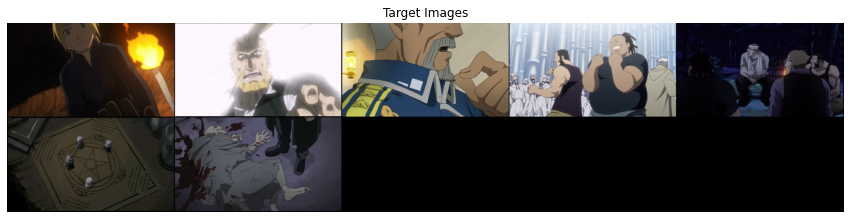

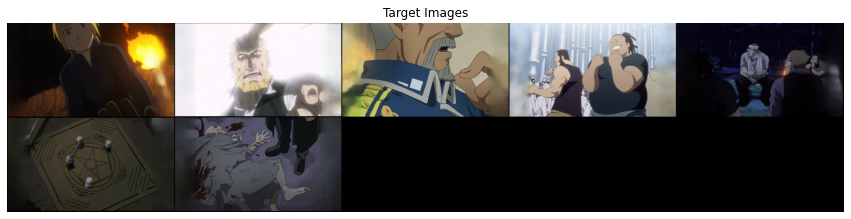

In [ ]:
batch = next(iter(dataloader_train))
batch = batch.to(device)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

_, batch_out = gen(apply_mask(batch.to(device), IMG_WIDTH, SINGLE_SIDE))
batch_out = apply_comp(batch, batch_out, IMG_WIDTH, SINGLE_SIDE)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch_out.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

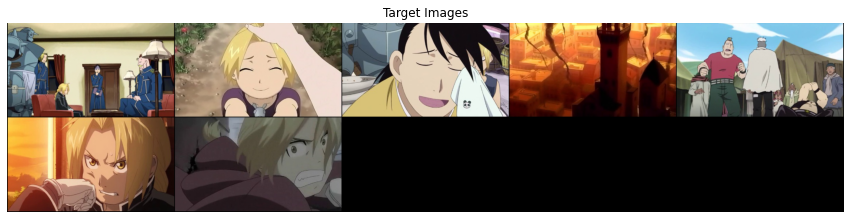

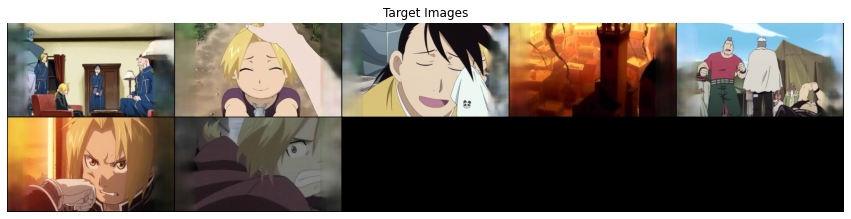

In [8]:
batch = next(iter(dataloader_val))
batch = batch.to(device)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

_, batch_out = gen(apply_mask(batch, IMG_WIDTH, SINGLE_SIDE))
batch_out = apply_comp(batch, batch_out, IMG_WIDTH, SINGLE_SIDE)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch_out[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

In [9]:
# adds -1 padding to the sides of images that are in 4:3 aspect ratio
def apply_padding(img, img_height, single_side):
    if len(img.shape) > 3:
        padding = torch.zeros([BATCH_SIZE // 2, 3, img_height, single_side])
        padding = padding.new_full((BATCH_SIZE // 2, 3, img_height, single_side), -1)
        img_cat = torch.cat((padding.to(device), img.to(device), padding.to(device)), 3)
    else:
        padding = torch.zeros([3, img_height, single_side])
        padding = padding.new_full((3, img_height, single_side), -1)
        img_cat = torch.cat((padding, img, padding), 2)

    return img_cat

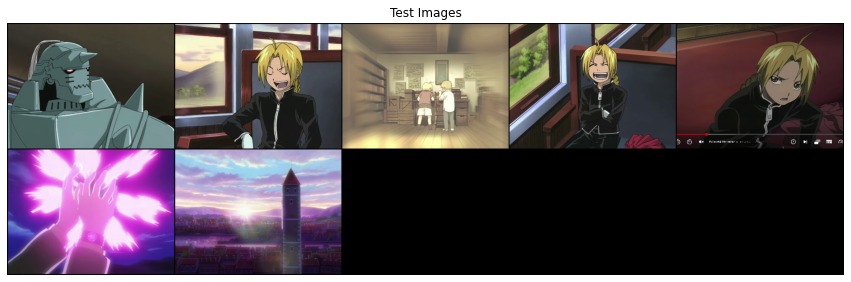

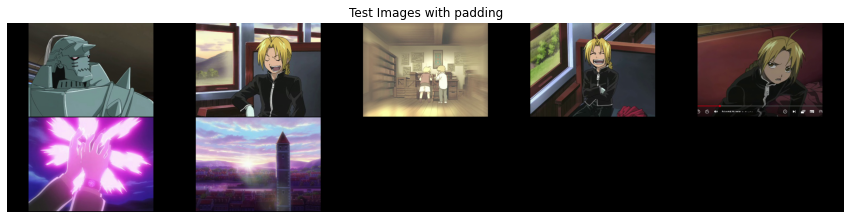

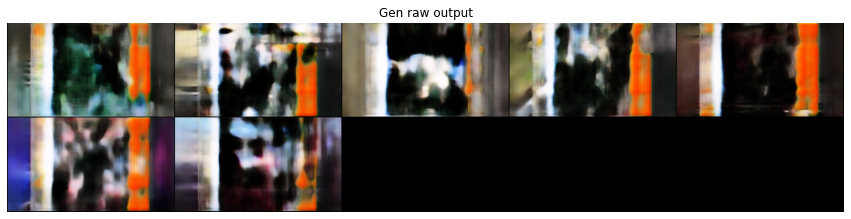

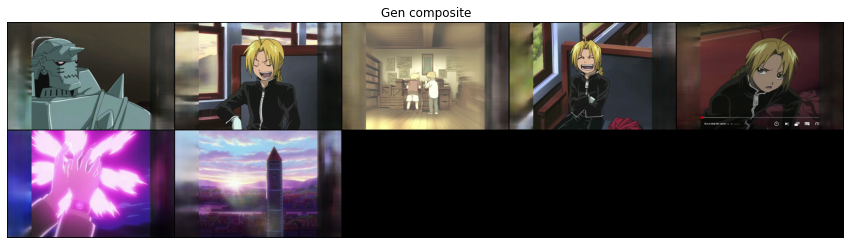

In [11]:
batch = next(iter(dataloader_test))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Test Images')
plt.imshow(np.transpose(vutils.make_grid(batch[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Test Images with padding')
plt.imshow(np.transpose(vutils.make_grid(apply_padding(batch[:64], IMG_HEIGHT, SINGLE_SIDE), padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

_, batch_out = gen(apply_padding(batch, IMG_HEIGHT, SINGLE_SIDE))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Gen raw output')
plt.imshow(np.transpose(vutils.make_grid(batch_out[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

batch_out = apply_comp(batch.to(device), batch_out.to(device), IMG_WIDTH, SINGLE_SIDE)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Gen composite')
plt.imshow(np.transpose(vutils.make_grid(batch_out[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))